# Text Classification on Amazon Reviews

This notebook plots the results of various optimization algorithms on the Amazon Reviews distribution shift benchmark.

In [304]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import pickle
import numpy as np
import pandas as pd

sys.path.append("..")
from src.utils.io import var_to_str, get_path, load_results
from src.utils.data import load_dataset

In [305]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 28
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [306]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/",result_dir="",lbfgs_path=""
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=lbfgs_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

def plot_traj(
    ax,
    dataset,
    model_cfg,
    plot_cfg,
    seeds,
    out_path="../results/",
    verbose=False,
    n_points=16,
    markersize=8,
    n_epochs=None,
):
    filename = plot_cfg["optimizer"]  # "code" name (e.g. "lsvrg")
    label = plot_cfg["label"]  # display name
    color = plot_cfg["color"]
    linestyle = plot_cfg["linestyle"]

    X_train = load_dataset(dataset, data_path="../data/")[0]
    n = len(X_train)
    d = X_train.shape[1]

    path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
   
    df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
    opt = pickle.load(open(os.path.join(path, "best_cfg.p"), "rb"))
    if verbose:
        print(f"{filename} best config:", opt)
    avg_train_loss = torch.tensor(df["average_train_loss"])
    epoch_len = opt["epoch_len"]

    epochs = torch.arange(len(avg_train_loss))
    subopt = get_suboptimality(
        dataset, model_cfg, avg_train_loss, out_path=out_path
    )
    # rescale algorithms that make multiple gradient evaluations per iteration
    if filename == "lsvrg":
        if epoch_len:
            x = epochs * (epoch_len + n) / n
        else:
            x = epochs * 2
    elif filename == "moreau":
        if epoch_len:
            x = epochs * 2 * epoch_len / n
        else:
            x = epochs * 2
    else:
        if epoch_len:
            x = epochs * min(epoch_len * 64, n) / n
        else:
            x = epochs
    if n_epochs:
        idx = x < min(len(subopt), n_epochs)
    else:
        idx = x < len(subopt)
    downsample = torch.sum(idx).item() // n_points
    ax.plot(
        x[idx][::downsample],
        subopt[idx][::downsample],
        color=color,
        label=label,
        linestyle=linestyle,
        marker=plot_cfg["marker"],
        markersize=markersize,
    )

In [307]:
dataset = "amazon"
loss = "multinomial_cross_entropy"
n_class = 5
l2_reg = 1.0
shift_cost = 1.0

result_dir = "../results"

In [308]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },
    {
        "optimizer": "lsvrg",
        "label": "LSVRG",
        "color": "cadetblue",
        "linestyle": "solid",
        "marker": "o",
    },
]

In [309]:
import inspect

In [310]:
def var_to_str(var):
    translate_table = {ord(c): None for c in ",()[]"}
    translate_table.update({ord(" "): "_"})

    if type(var) == dict:
        sortedkeys = sorted(var.keys(), key=lambda x: x.lower())
        var_str = [
            key + "_" + var_to_str(var[key])
            for key in sortedkeys
            if var[key] is not None
        ]
        var_str = "_".join(var_str)
    elif inspect.isclass(var):
        raise NotImplementedError("Do not give classes as items in cfg inputs")
    elif type(var) in [list, set, frozenset, tuple]:
        value_list_str = [var_to_str(item) for item in var]
        var_str = "_".join(value_list_str)
    elif isinstance(var, float):
        var_str = "{0:1.2e}".format(var)
    elif isinstance(var, int):
        var_str = str(var)
    elif isinstance(var, str):
        var_str = var
    elif var is None:
        var_str = str(var)
    else:
        raise NotImplementedError
    return var_str
def get_iterates_path(levels, out_path="results/"):
    path = out_path
    for item in levels:
        path = os.path.join(path, item + "/")
    return path

In [311]:
def get_iterates(dataset,objective  ,optimizer, seed=1, result_dir=None):
    loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": "multinomial_cross_entropy",
        "n_class": 5,
        "shift_cost": shift_cost
    }
    best_path = get_iterates_path(result_dir,model_cfg=model_cfg,datset=dataset)
    best_path = os.path.join(best_path,optimizer+"/best_cfg.p")
    optim_cfg = None
    with open(best_path, 'rb') as file:
        optim_cfg = pickle.load(file)
    print("objective",objective,"specific_cfg",optim_cfg)
    path = get_iterates_path([dataset, var_to_str(model_cfg), var_to_str(optim_cfg)], out_path=result_dir)
    f = os.path.join(path, f"seed_{seed}.p")
    data = pickle.load(open(f, "rb"))
    metrics_data = data['metrics']    
    return metrics_data['iterates']

In [319]:
def plot_ax(ax, seeds, objective, plot_cfg, dataset, epoch_len=None, n=4000, downsample=4, max_epoch=32, markersize=7, out_path="../results/",result_dir="C:\\PrivacyInAI\\code\\prospect\\experiments\\results",lbfgs_path="C:\\PrivacyInAI\\code\\prospect\\results"):
    
    optimizer = plot_cfg['optimizer']
    if dataset =="amazon":
        model_cfg = {
            "objective": objective, 
            "l2_reg": l2_reg, 
            "loss": "multinomial_cross_entropy",
            "n_class": 5,
            "shift_cost": shift_cost
        }
    if dataset =="acsincome":
        model_cfg = {
            "objective": objective, 
            "l2_reg": l2_reg, 
            "loss": "binary_cross_entropy" if dataset == "diabetes" else "squared_error", 
            "n_class": None,
            "shift_cost": shift_cost
        }
    for seed in seeds:
        filename = plot_cfg["optimizer"]
        path = get_path([dataset, var_to_str(model_cfg), filename], out_path=result_dir)
        df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
        
        #df_1 = pickle.load(open(os.path.join(path, "best_cfg.p"), "rb"))
        #print(df_1)
        train_loss = torch.tensor(df["average_train_loss"])
        epochs = torch.arange(len(train_loss))
        subopt = get_suboptimality(
            dataset, model_cfg, train_loss, out_path=result_dir,lbfgs_path=lbfgs_path
        )
        if optimizer == "lsvrg":
            x = epochs * 2
        elif optimizer in ["sgd", "srda"]:
            x = epochs
        else:
            x = epochs
        idx = (x <= max_epoch)
        if ax!= None:
            ax.plot(
                x[idx][::downsample], 
                subopt[idx][::downsample], 
                label=plot_cfg['label'], 
                color=plot_cfg['color'],
                marker=plot_cfg['marker'],
                markersize=markersize
            )
        return subopt
        


In [313]:
X_train, y_train, X_test, y_test = load_dataset("amazon", data_path="../data/")
z_test = torch.tensor(np.load("../data/amazon/z_test.npy"))

print(X_test.shape)
print(y_test.shape)
print(z_test.shape)

torch.Size([10000, 107])
torch.Size([10000])
torch.Size([10000, 6])


In [314]:
metadata = pd.DataFrame(z_test).drop(columns=[0, 1, 5])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   2       10000 non-null  int64
 1   3       10000 non-null  int64
 2   4       10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [315]:
metadata.head()

,2,3,4
0,4,19,0
1,2,20,4
2,2,18,4
3,2,15,3
4,2,16,0


In [316]:
def get_group_error(column, optimizer, objective):
    iterates = get_iterates(objective, optimizer)

    df = metadata.copy()

    for i, w in enumerate(iterates):
        logits = X_test @ w
        df[f"error_{i}"] = (y_test != torch.argmax(logits, dim=1)).int()

    cols = [column] + [f"error_{i}" for i in range(len(iterates))]

    # returns (T, G) numpy array where T is the number of iterates and G is the number of groups.
    return df[cols].groupby([column]).mean().to_numpy().T

TypeError: get_iterates() missing 1 required positional argument: 'optimizer'

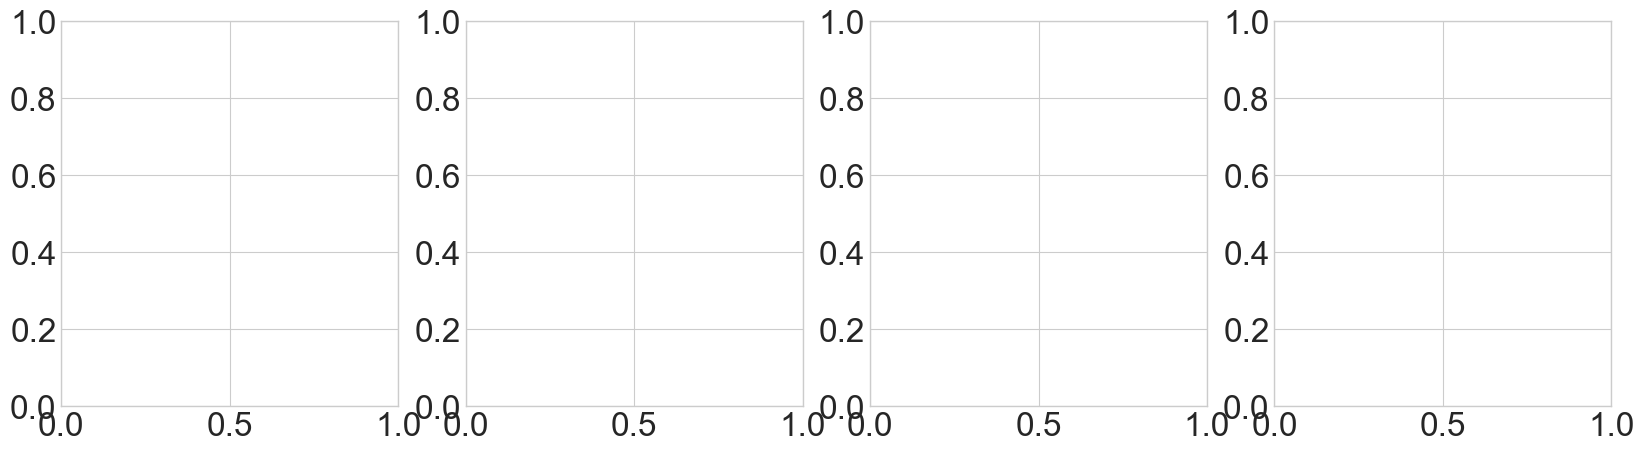

In [317]:

column = 4
seeds = [1]
objectives = ["superquantile", "esrm", "superquantile", "esrm"]
obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
sns.set_style("whitegrid")

# fig, ax = plt.subplots(2, len(objectives), figsize=(5 * len(objectives), 10), sharey="row")
fig, ax = plt.subplots(1, 4, figsize=(20, 5))


for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        optimizer = plot_cfg["optimizer"]
        group_error = get_group_error(column, optimizer, objective)
        yy = np.max(group_error, axis=1)
        xx = np.arange(len(yy))

        print(f"{optimizer} {objective} mean: {yy[-10:].mean()}")
        print(f"{optimizer} {objective} mean: {yy[-10:].std()}")

        markersize = 14
        downsample = 2
        ax[2 * j + 1].plot(xx, yy, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[2 * j].set_title(obj_names[j], fontsize=28)
        ax[2 * j + 1].set_title(obj_names[j], fontsize=28)

        plot_ax(ax[2 * j], seeds, objective, plot_cfg, dataset, markersize=15)
        ax[2 * j].set_yscale("log")
        # ax[2 * j].set_xticklabels([])
        # ax[1, j].hlines(y=1.0, xmin=0, xmax=32, color="gray", linestyle="dashed")


for k in range(4):
    ax[k].set_xlabel(f"Passes", fontsize=24)
ax[0].set_ylabel(f"Suboptimality", fontsize=32)
ax[1].set_ylabel(f"Worst Group Error", fontsize=32)
ax[2].set_ylabel(f"Suboptimality", fontsize=32)
ax[3].set_ylabel(f"Worst Group Error", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.savefig(f"../figures/amazon_training_curves.pdf", bbox_inches="tight")
plt.show()

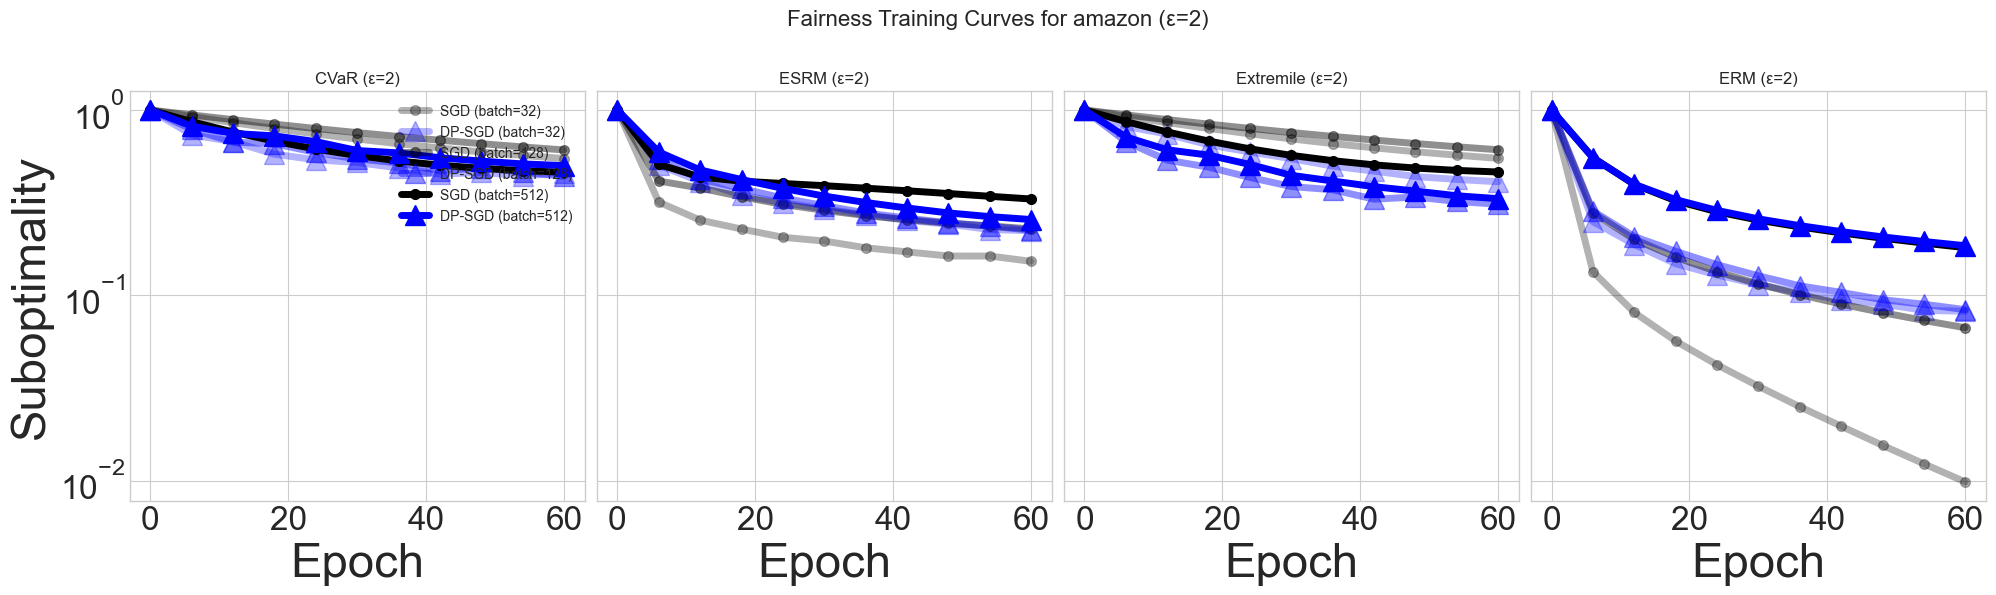

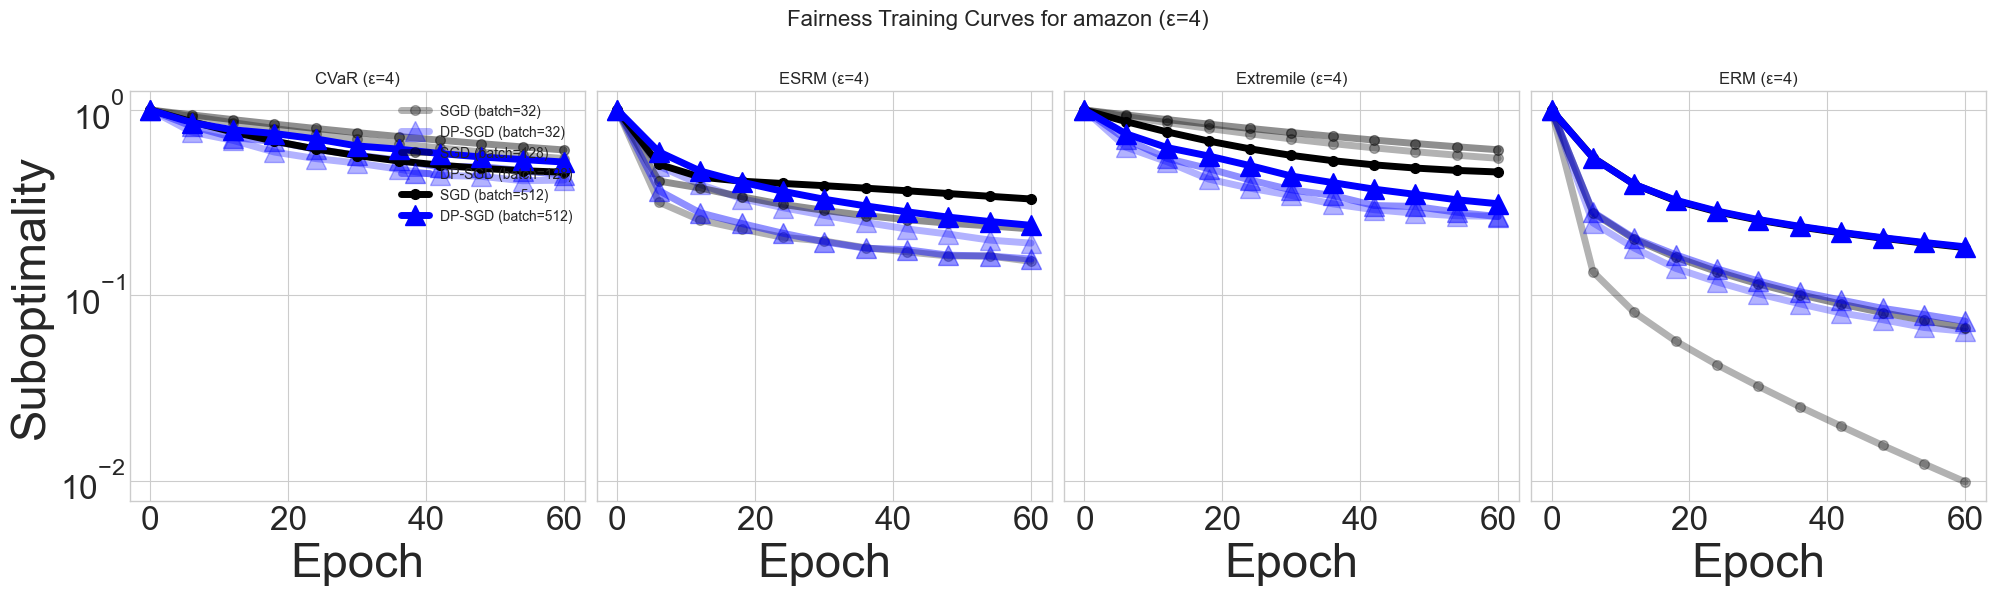

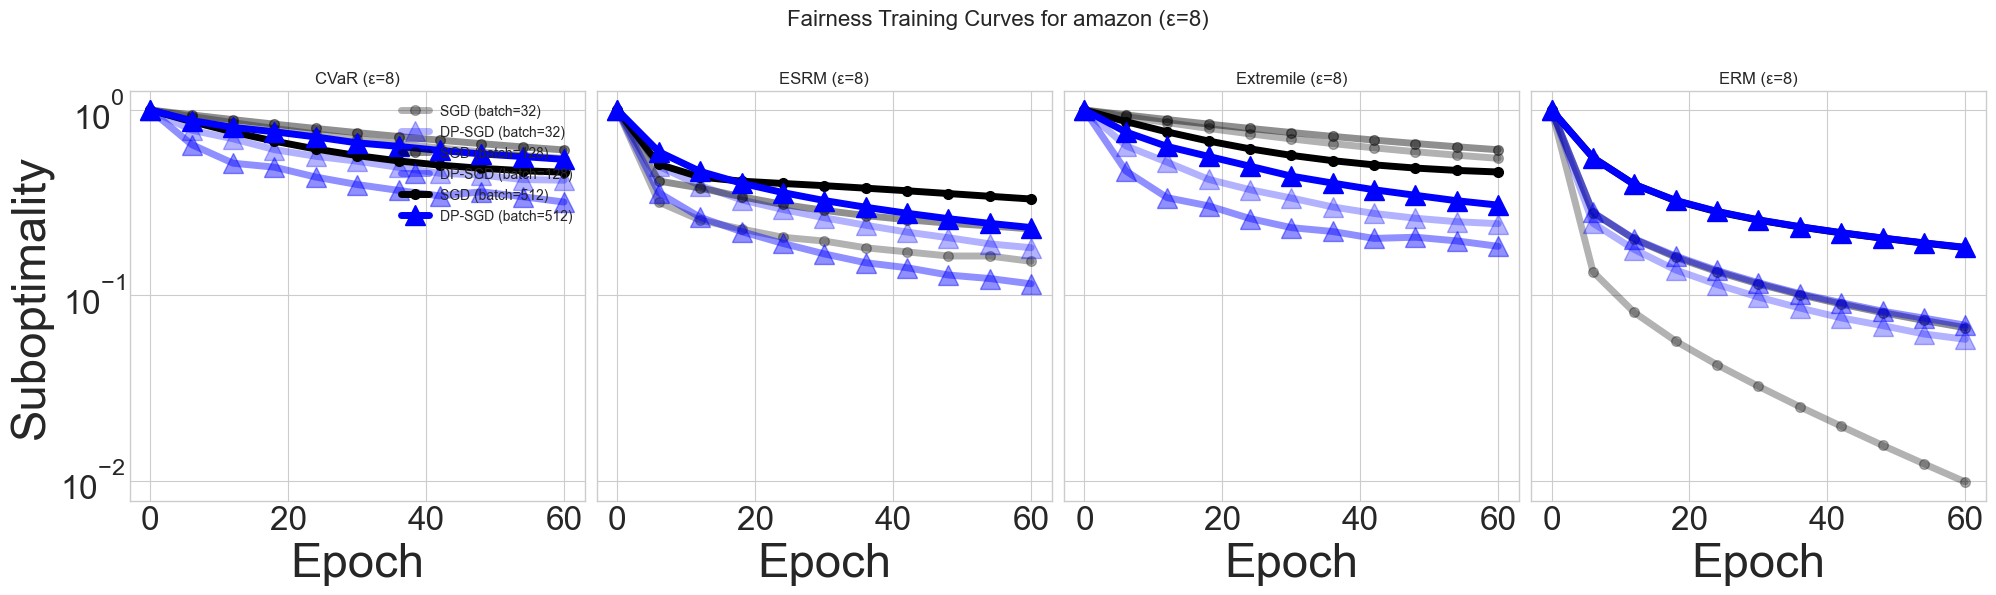

In [320]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8]
batch_sizes = [32, 128, 512]
# Objective names
objectives = ["superquantile", "esrm","extremile","erm"]
obj_names = ["CVaR", "ESRM", "Extremile", "ERM"]

def get_color_intensity(batch_size, min_batch=32, max_batch=512):
    intensity = 0.3 + 0.7 * (batch_size - min_batch) / (max_batch - min_batch)
    return max(0, min(intensity, 1))  # Clamp intensity between 0 and 1

def get_plot_cfg(optimizer, batch_size):
    intensity = get_color_intensity(batch_size)
    if optimizer == "sgd":
        return {
            "optimizer": optimizer,
            "label": f"SGD (batch={batch_size})",
            "color": (0, 0, 0, intensity),  # Black with varying intensity
            "linestyle": "solid",
            "marker": ".",
        }
    else:  # dp_sgd
        return {
            "optimizer": optimizer,
            "label": f"DP-SGD (batch={batch_size})",
            "color": (0, 0, 1, intensity),  # Blue with varying intensity
            "linestyle": "solid",
            "marker": "^",
        }

# Create separate plots for each epsilon
for epsilon in epsilon_values:
    # Set up a 1x4 grid of subplots for the 4 objectives
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
    
    dataset = "amazon"
    for batch_size in batch_sizes:
        for objective_idx, objective in enumerate(objectives):
            ax = axes[objective_idx]  # Select the subplot for the current objective
            
            # Create plot configurations for the current batch size
            plot_cfgs = [
                get_plot_cfg("sgd", batch_size),
                get_plot_cfg("dp_sgd", batch_size)
            ]
            
            for plot_cfg in plot_cfgs:
                optimizer = plot_cfg["optimizer"]
                result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
                lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
                
                # Assuming plot_ax is defined elsewhere and handles plotting
                plot_ax(ax, [1], objective, plot_cfg, dataset, 
                        max_epoch=64, downsample=6, markersize=14, 
                        result_dir=result_dir, lbfgs_path=lbfgs_path)
            
            # Set title and label for each subplot using obj_names
            ax.set_title(f'{obj_names[objective_idx]} (ε={epsilon})', fontsize=12)
            ax.set_xlabel('Epoch')
            if objective_idx == 0:  # Only set the ylabel for the first subplot
                ax.set_ylabel('Suboptimality')
            ax.set_yscale('log')
    
    # Add legend to the first subplot only, adjust size and position
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc='upper right', fontsize=10)  # Adjusted font size and position
    
    plt.suptitle(f'Fairness Training Curves for amazon (ε={epsilon})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.savefig(f"../figures/fairness_training_curves_amazon_eps_{epsilon}.pdf", 
                bbox_inches="tight")
    plt.show()
    

In [321]:
# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8,16]
batch_sizes = [8,16,32, 64, 128, 256, 512]
# Objective names
objectives = ["superquantile", "esrm", "extremile", "erm"]

# Store the best batch sizes for dp_sgd and sgd
best_dp_sgd_batch_sizes = {}
best_sgd_batch_size = {}  # Change to store a single best batch size for SGD

# Function to evaluate and store best batch sizes
def evaluate_and_store_best_batch_sizes(method, best_batch_sizes, is_sgd=False):
    for epsilon in epsilon_values:
        print(epsilon)
        dataset = "acsincome"
        
        for batch_size in batch_sizes:
            for objective_idx, objective in enumerate(objectives):
                # Get plot configuration
                plot_cfg = get_plot_cfg(method, batch_size)
                optimizer = plot_cfg["optimizer"]
                result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
                lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
                
                try:
                    # Evaluate the method
                    subopt = plot_ax(None, [1], objective, plot_cfg, 
                                     dataset, max_epoch=64, downsample=6, 
                                     markersize=14, result_dir=result_dir, lbfgs_path=lbfgs_path)
                    
                    # Store the best batch size based on suboptimality
                    if is_sgd:
                        # For SGD, store the best batch size across all epsilons
                        if objective not in best_sgd_batch_size:
                            best_sgd_batch_size[objective] = (subopt, batch_size)
                        else:
                            # Update if the new suboptimality is better (lower is better)
                            if min(subopt) < min(best_sgd_batch_size[objective][0]):
                                best_sgd_batch_size[objective] = (subopt, batch_size)
                    else:
                        # For DP-SGD, store the best batch size per epsilon
                        if objective not in best_batch_sizes:
                            best_batch_sizes[objective] = {epsilon: (subopt, batch_size)}
                        else:
                            if epsilon not in best_batch_sizes[objective]:
                                best_batch_sizes[objective][epsilon] = (subopt, batch_size)
                            else:
                                # Update if the new suboptimality is better (lower is better)
                                if min(subopt) < min(best_batch_sizes[objective][epsilon][0]):
                                    best_batch_sizes[objective][epsilon] = (subopt, batch_size)
                except Exception as e:
                    #print(epsilon)
                    pass
                    # print(f"Error occurred for {method} with objective {objective}, "
                    #       f"epsilon {epsilon}, batch size {batch_size}: {e}")
                    # Continue to the next batch size

# Evaluate for SGD
evaluate_and_store_best_batch_sizes("sgd", best_sgd_batch_size, is_sgd=True)

# Evaluate for DP-SGD
evaluate_and_store_best_batch_sizes("dp_sgd", best_dp_sgd_batch_sizes, is_sgd=False)

# Print only the best batch sizes
print("Best dp_sgd batch sizes:")
for obj, eps_dict in best_dp_sgd_batch_sizes.items():
    print(f"{obj}: {[bs for _, (subopt, bs) in eps_dict.items()]}")  # Print only batch sizes for each epsilon

print("Best sgd batch sizes:")
for obj, (subopt, bs) in best_sgd_batch_size.items():
    print(f"{obj}: {bs}")  # Print only the best batch size for SGD

2
4
8
16
2
4
8
16
Best dp_sgd batch sizes:
superquantile: [128, 256, 256, 256]
esrm: [256, 256, 128, 256]
extremile: [128, 256, 256, 256]
erm: [128, 256, 512, 512]
Best sgd batch sizes:
superquantile: 128
esrm: 128
extremile: 128
erm: 128


In [322]:
# Assuming best_dp_sgd_batch_sizes and best_sgd_batch_size are already defined

# Create a new dictionary for batch sizes
best_dp_sgd_batch_sizes_only = {}
for obj, eps_dict in best_dp_sgd_batch_sizes.items():
    best_dp_sgd_batch_sizes_only[obj] = [bs for _, (subopt, bs) in eps_dict.items()]

best_sgd_batch_size_only = {}
for obj, (subopt, bs) in best_sgd_batch_size.items():
    best_sgd_batch_size_only[obj] = bs

# Print the new dictionaries
print("Best dp_sgd batch sizes only:")
for obj, batch_sizes in best_dp_sgd_batch_sizes_only.items():
    print(f"{obj}: {batch_sizes}")

print("Best sgd batch sizes only:")
for obj, batch_size in best_sgd_batch_size_only.items():
    print(f"{obj}: {batch_size}")

Best dp_sgd batch sizes only:
superquantile: [128, 256, 256, 256]
esrm: [256, 256, 128, 256]
extremile: [128, 256, 256, 256]
erm: [128, 256, 512, 512]
Best sgd batch sizes only:
superquantile: 128
esrm: 128
extremile: 128
erm: 128


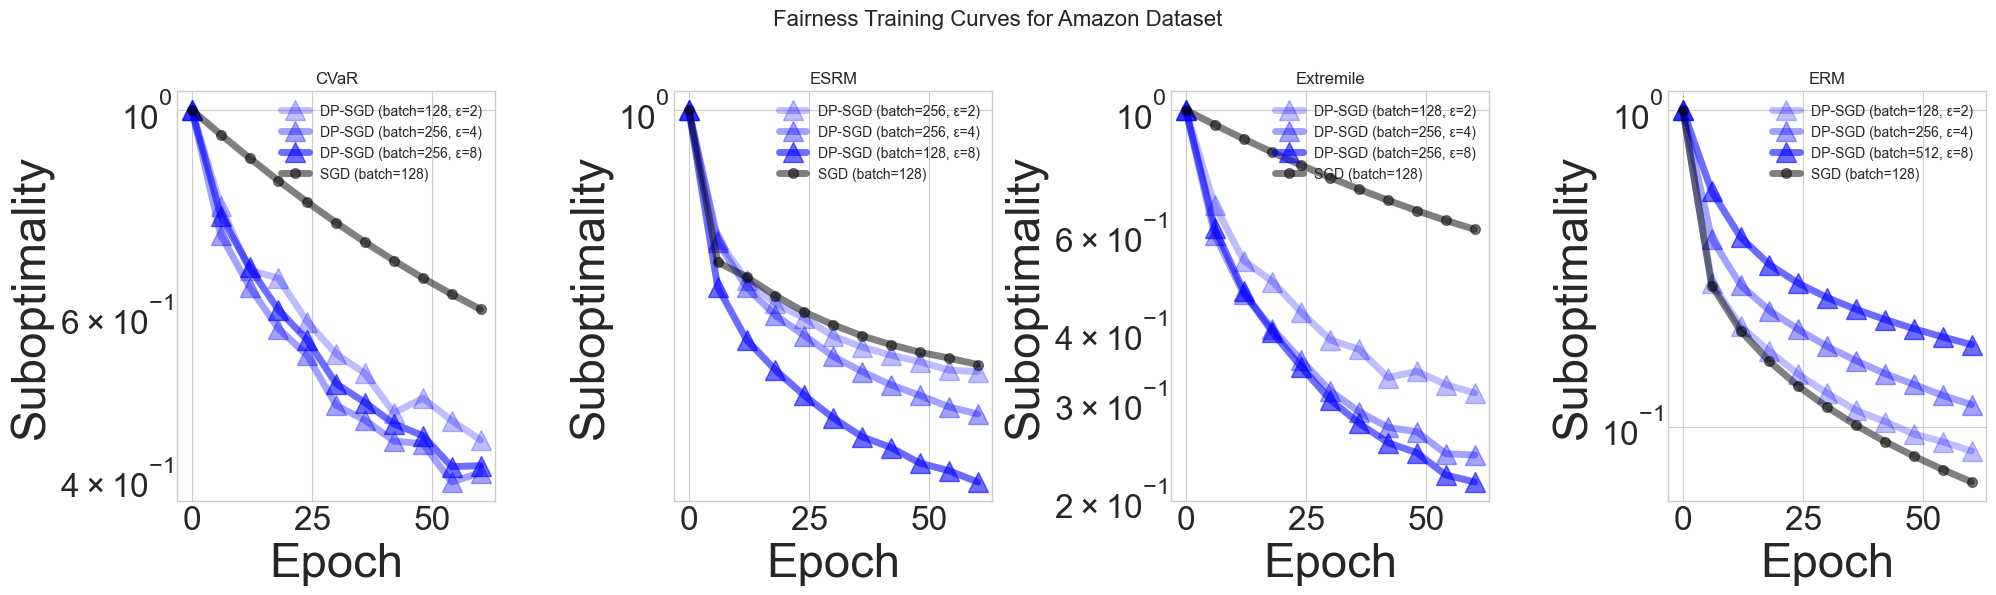

In [323]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8]
#batch_sizes = [32, 128, 512]
# Objective names
objectives = ["superquantile", "esrm", "extremile", "erm"]
obj_names = ["CVaR", "ESRM", "Extremile", "ERM"]

def get_color_intensity(epsilon, min_epsilon=0, max_epsilon=16):
    # Invert intensity based on epsilon: lower epsilon means higher intensity
    intensity = 0.85*((epsilon - min_epsilon) / (max_epsilon - min_epsilon)) +0.15
    return max(0, min(intensity, 1))  # Clamp intensity between 0 and 1

def get_plot_cfg(optimizer, batch_size, epsilon=None):
    intensity = get_color_intensity(epsilon) if epsilon is not None else 0.5  # Default intensity for sgd
    if optimizer == "sgd":
        return {
            "optimizer": optimizer,
            "label": f"SGD (batch={batch_size})",
            "color": (0, 0, 0, intensity),  # Black with varying intensity
            "linestyle": "solid",
            "marker": ".",
        }
    else:  # dp_sgd
        return {
            "optimizer": optimizer,
            "label": f"DP-SGD (batch={batch_size}, ε={epsilon})",
            "color": (0, 0, 1, intensity),  # Blue with varying intensity
            "linestyle": "solid",
            "marker": "^",
        }

# Create a single figure with subplots for each objective
fig, axs = plt.subplots(1, len(objectives), figsize=(20, 6))  # One row, multiple columns

# Iterate through each objective and plot
for objective_idx, objective in enumerate(objectives):
    ax = axs[objective_idx]  # Get the current axis for the subplot
    
    # Get the best batch sizes for dp_sgd and sgd
    best_dp_sgd_batch_size = best_dp_sgd_batch_sizes_only[objective]
    best_sgd_batch_size = best_sgd_batch_size_only[objective]  # Assuming we want the batch size for epsilon=2

    # Plot dp_sgd for all epsilon values
    for i,epsilon in enumerate(epsilon_values):
        batch_size = best_dp_sgd_batch_size[i]
        plot_cfg = get_plot_cfg("dp_sgd", batch_size, epsilon)
        
        result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
        lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
        
        # Assuming plot_ax is defined elsewhere and handles plotting
        plot_ax(ax, [1], objective, plot_cfg, dataset="amazon", 
                max_epoch=64, downsample=6, markersize=14, 
                result_dir=result_dir, lbfgs_path=lbfgs_path)

    # Plot sgd only once
    plot_cfg = get_plot_cfg("sgd", best_sgd_batch_size)
    result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{2:.6f}_{best_sgd_batch_size}"  # Using epsilon=2 for sgd
    lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
    
    plot_ax(ax, [1], objective, plot_cfg, dataset="amazon", 
            max_epoch=64, downsample=6, markersize=14, 
            result_dir=result_dir, lbfgs_path=lbfgs_path)

    # Set title and label for the subplot
    ax.set_title(f'{obj_names[objective_idx]}', fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Suboptimality')
    ax.set_yscale('log')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', fontsize=10)

# Set the overall title for the figure
plt.suptitle('Fairness Training Curves for Amazon Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.savefig(f"../figures/fairness_training_curves_amazon_eps_{epsilon}.pdf", 
                bbox_inches="tight")

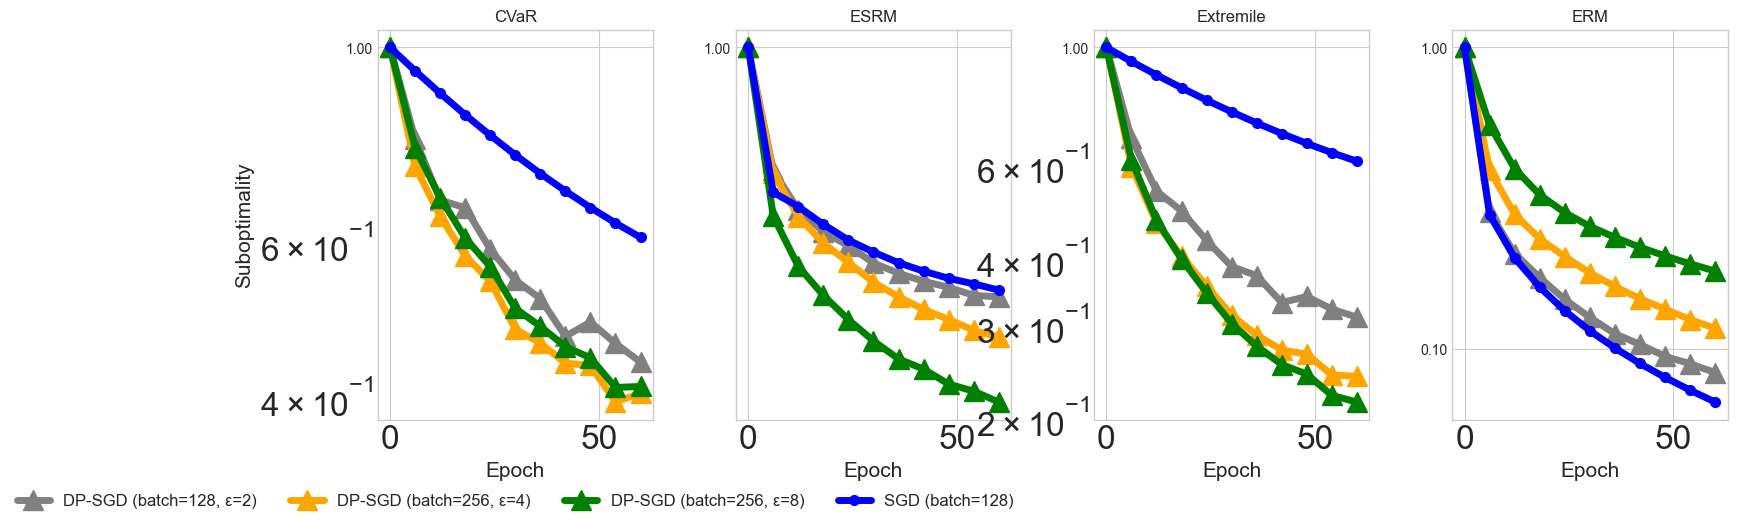

In [324]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8]
# Batch sizes associated with each epsilon value for dp_sgd
# Example values; replace with actual best values


# Objective names
objectives = ["superquantile", "esrm", "extremile", "erm"]
obj_names = ["CVaR", "ESRM", "Extremile", "ERM"]

# Define colors for each epsilon
colors = {
    2: 'grey',
    4: 'orange',
    8: 'green'
}

def get_plot_cfg(optimizer, batch_size, color, epsilon=None):
    if optimizer == "sgd":
        return {
            "optimizer": optimizer,
            "label": f"SGD (batch={batch_size})",
            "color": "blue",
            "linestyle": "solid",
            "marker": ".",
        }
    else:  # dp_sgd
        return {
            "optimizer": optimizer,
            "label": f"DP-SGD (batch={batch_size}, ε={epsilon})",
            "color": color,
            "linestyle": "solid",
            "marker": "^",
        }

# Create a single figure with subplots for each objective
fig, axs = plt.subplots(1, len(objectives), figsize=(15, 6))  # One row, multiple columns

import matplotlib.ticker as ticker

# Iterate through each objective and plot
for objective_idx, objective in enumerate(objectives):
    ax = axs[objective_idx]  # Get the current axis for the subplot

    # Get the best batch sizes for dp_sgd and sgd
    best_dp_sgd_batch_size = best_dp_sgd_batch_sizes_only[objective]
    best_sgd_batch_size = best_sgd_batch_size_only[objective]

    # Plot dp_sgd for all epsilon values
    for i, epsilon in enumerate(epsilon_values):
        batch_size = best_dp_sgd_batch_size[i]
        plot_cfg = get_plot_cfg("dp_sgd", batch_size, colors[epsilon], epsilon)
        
        result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
        lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
        
        plot_ax(ax, [1], objective, plot_cfg, dataset="amazon", 
                max_epoch=64, downsample=6, markersize=14, 
                result_dir=result_dir, lbfgs_path=lbfgs_path)

    # Plot sgd only once
    plot_cfg = get_plot_cfg("sgd", best_sgd_batch_size, colors[2])  # Using epsilon=2 color
    result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{2:.6f}_{best_sgd_batch_size}"
    lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
    
    plot_ax(ax, [1], objective, plot_cfg, dataset="amazon", 
            max_epoch=64, downsample=6, markersize=14, 
            result_dir=result_dir, lbfgs_path=lbfgs_path)

    # Set title and label for the subplot
    ax.set_title(f'{obj_names[objective_idx]}', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=15)
    
    # Format y-axis for scientific notation and smaller font size
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
    ax.tick_params(axis='y', labelsize=10)  # Set font size smaller
    
    # Set y-axis label for the first subplot only
    if objective_idx == 0:
        ax.set_ylabel('Suboptimality', fontsize=15)

    # Add legend only for the first subplot
    if objective_idx == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='upper center', fontsize=12, bbox_to_anchor=(0.5, -0.15), ncol=4)

# Adjust layout to reduce gaps between subplots and remove extra left space
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.2, wspace=0.3, hspace=0.4)

# Save the figure
plt.savefig(f"../figures/fairness_training_curves_amazon_eps_{max(epsilon_values)}.pdf", 
            bbox_inches="tight")

# Show the plot
plt.show()


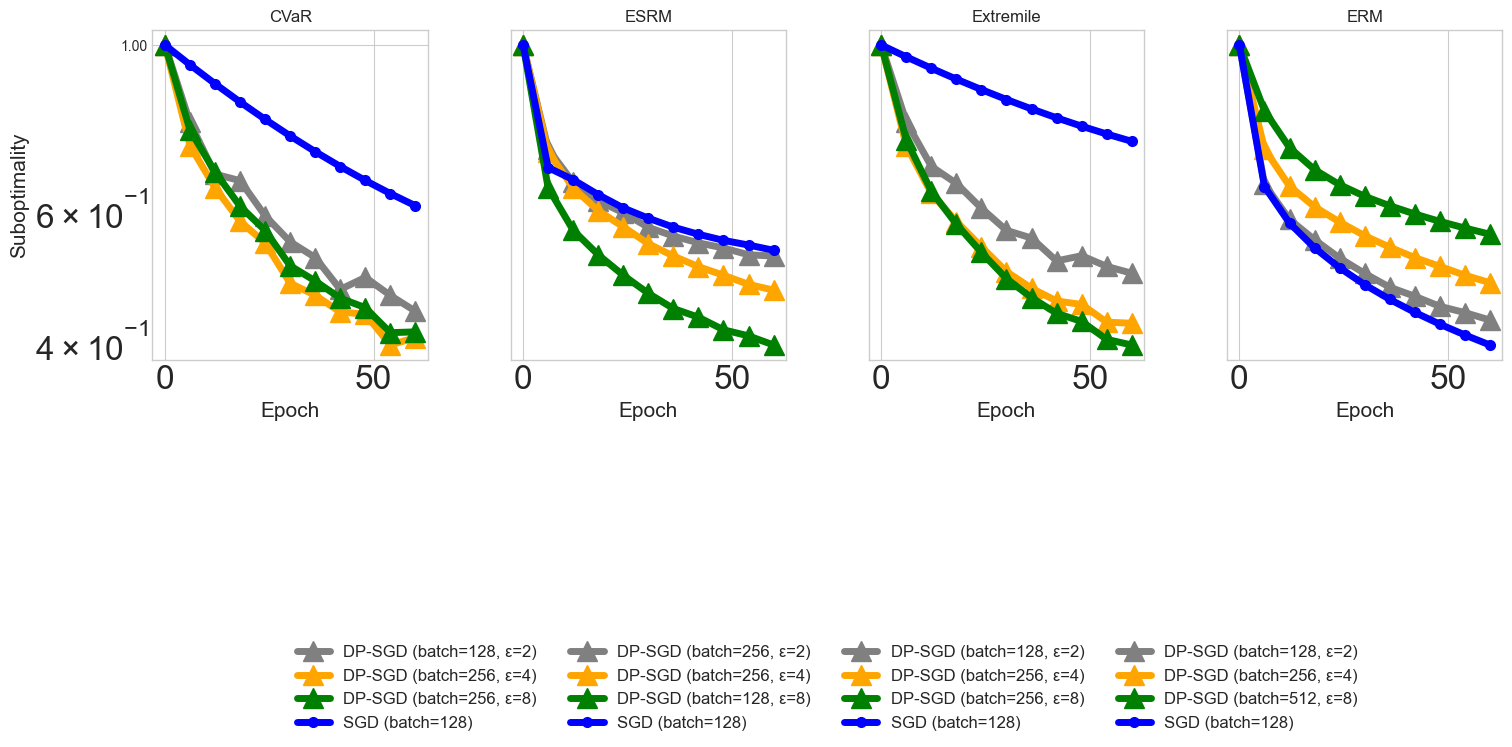

In [325]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8]
# Batch sizes associated with each epsilon value for dp_sgd
# Example values; replace with actual best values


# Objective names
objectives = ["superquantile", "esrm", "extremile", "erm"]
obj_names = ["CVaR", "ESRM", "Extremile", "ERM"]

# Define colors for each epsilon
colors = {
    2: 'grey',
    4: 'orange',
    8: 'green'
}

def get_plot_cfg(optimizer, batch_size, color, epsilon=None):
    if optimizer == "sgd":
        return {
            "optimizer": optimizer,
            "label": f"SGD (batch={batch_size})",
            "color": "blue",
            "linestyle": "solid",
            "marker": ".",
        }
    else:  # dp_sgd
        return {
            "optimizer": optimizer,
            "label": f"DP-SGD (batch={batch_size}, ε={epsilon})",
            "color": color,
            "linestyle": "solid",
            "marker": "^",
        }

# Create a single figure with subplots for each objective
fig, axs = plt.subplots(1, len(objectives), figsize=(15, 6))  # One row, multiple columns

import matplotlib.ticker as ticker

# Iterate through each objective and plot
for objective_idx, objective in enumerate(objectives):
    ax = axs[objective_idx]  # Get the current axis for the subplot

    # Get the best batch sizes for dp_sgd and sgd
    best_dp_sgd_batch_size = best_dp_sgd_batch_sizes_only[objective]
    best_sgd_batch_size = best_sgd_batch_size_only[objective]

    # Plot dp_sgd for all epsilon values
    for i, epsilon in enumerate(epsilon_values):
        batch_size = best_dp_sgd_batch_size[i]
        plot_cfg = get_plot_cfg("dp_sgd", batch_size, colors[epsilon], epsilon)
        
        result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
        lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
        
        plot_ax(ax, [1], objective, plot_cfg, dataset="amazon", 
                max_epoch=64, downsample=6, markersize=14, 
                result_dir=result_dir, lbfgs_path=lbfgs_path)

    # Plot sgd only once
    plot_cfg = get_plot_cfg("sgd", best_sgd_batch_size, colors[2])  # Using epsilon=2 color
    result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{2:.6f}_{best_sgd_batch_size}"
    lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
    
    plot_ax(ax, [1], objective, plot_cfg, dataset="amazon", 
            max_epoch=64, downsample=6, markersize=14, 
            result_dir=result_dir, lbfgs_path=lbfgs_path)

    # Set title and label for the subplot
    ax.set_title(f'{obj_names[objective_idx]}', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=15)
    
    # Format y-axis for scientific notation and smaller font size
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
    ax.tick_params(axis='y', labelsize=10)  # Set font size smaller
    
    # Set y-axis label for the first subplot only
    if objective_idx == 0:
        ax.set_ylabel('Suboptimality', fontsize=15)

    # Remove y-axis labels for all subplots except the first one
    if objective_idx != 0:
        ax.get_yaxis().set_visible(False)

# Adjust layout to reduce gaps between subplots and remove extra left space
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.3, wspace=0.3, hspace=0.4)

# Create legend below the plot
handles, labels = [], []
for objective_idx, objective in enumerate(objectives):
    ax = axs[objective_idx]
    handles_legend, labels_legend = ax.get_legend_handles_labels()
    handles.extend(handles_legend)
    labels.extend(labels_legend)

# Add legend below the plots, making it scrollable by adjusting figure height and bbox
fig.legend(handles, labels, loc='upper center', fontsize=12, bbox_to_anchor=(0.5, -0.15), ncol=4)

# Adjust layout to fit the legend well
fig.subplots_adjust(bottom=0.3)

# Save the figure
plt.savefig(f"../figures/fairness_training_curves_amazon_eps_{max(epsilon_values)}.pdf", 
            bbox_inches="tight")

# Show the plot
plt.show()


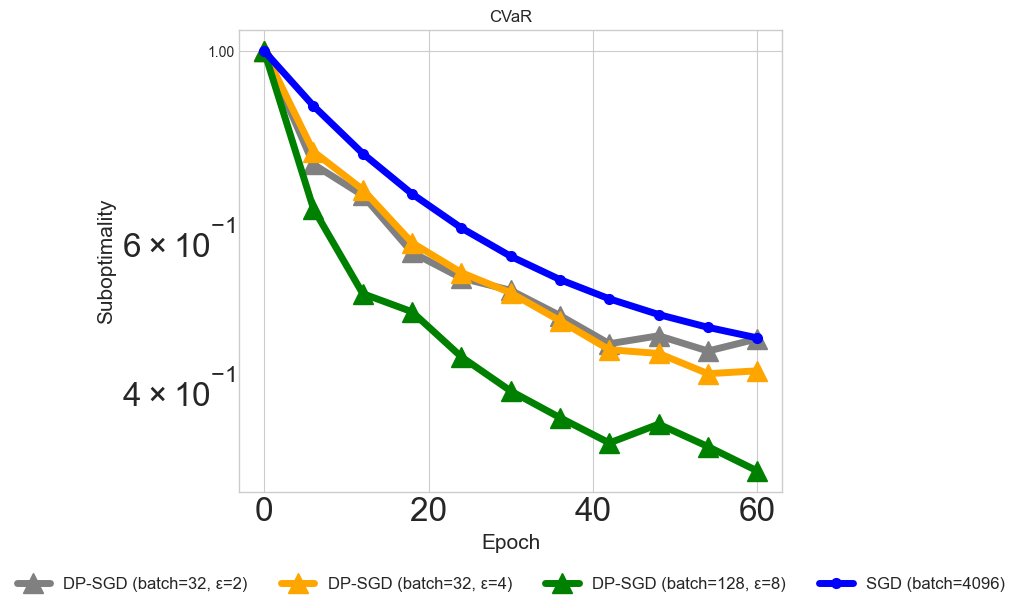

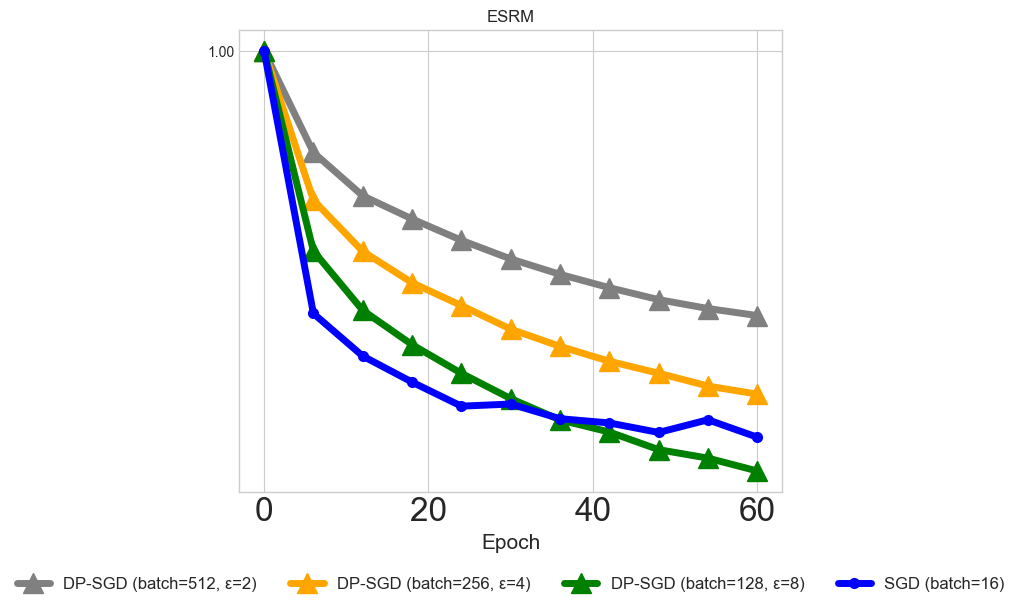

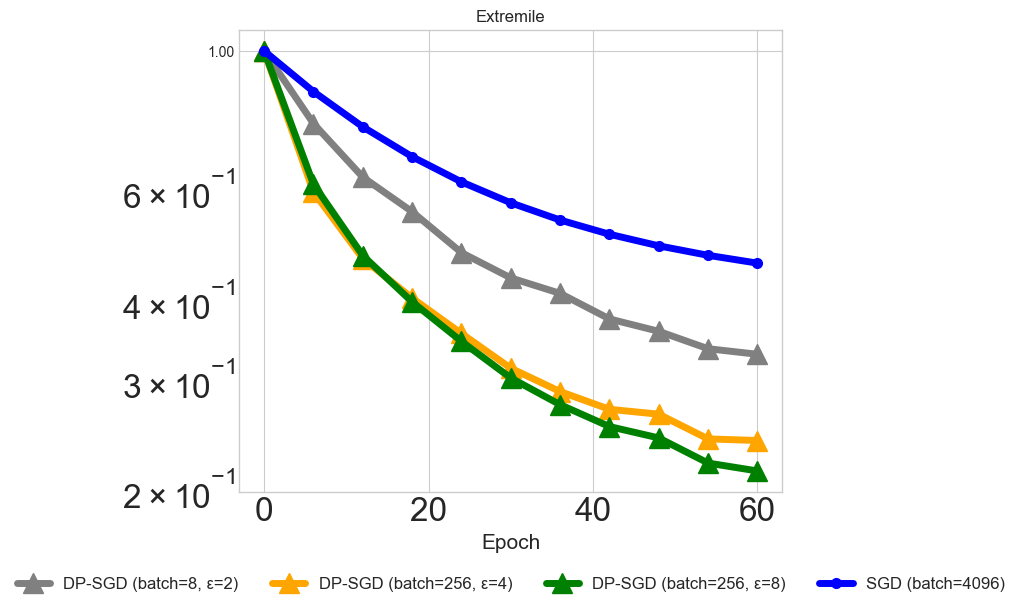

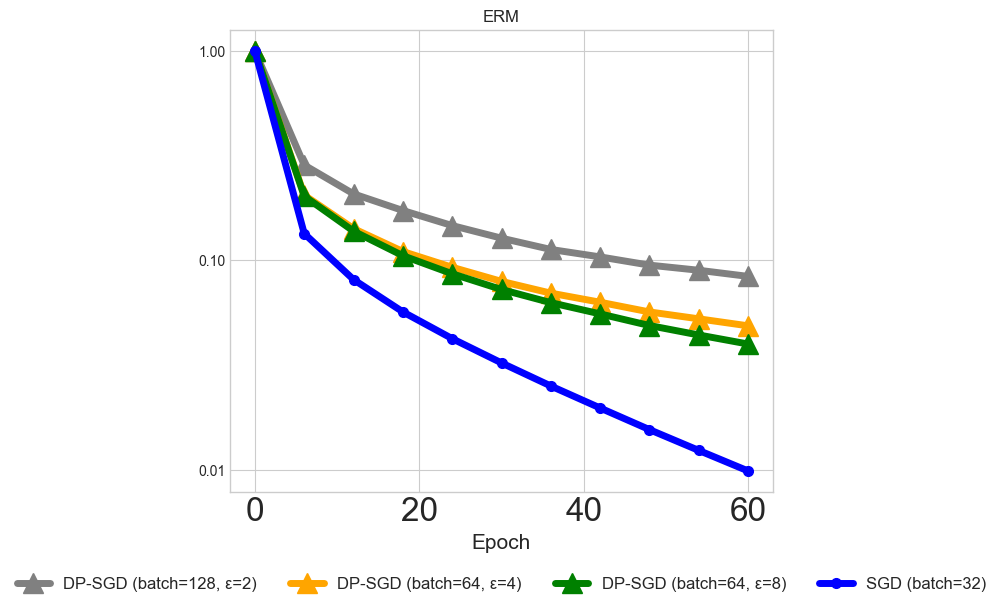

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of epsilon values and batch sizes
epsilon_values = [2, 4, 8]
# Batch sizes associated with each epsilon value for dp_sgd
# Example values; replace with actual best values


# Objective names
objectives = ["superquantile", "esrm", "extremile", "erm"]
obj_names = ["CVaR", "ESRM", "Extremile", "ERM"]

# Define colors for each epsilon
colors = {
    2: 'grey',
    4: 'orange',
    8: 'green'
}

def get_plot_cfg(optimizer, batch_size, color, epsilon=None):
    if optimizer == "sgd":
        return {
            "optimizer": optimizer,
            "label": f"SGD (batch={batch_size})",
            "color": "blue",
            "linestyle": "solid",
            "marker": ".",
        }
    else:  # dp_sgd
        return {
            "optimizer": optimizer,
            "label": f"DP-SGD (batch={batch_size}, ε={epsilon})",
            "color": color,
            "linestyle": "solid",
            "marker": "^",
        }

# Function to create individual plots for each objective
def create_individual_plot(objective, objective_idx):
    fig, ax = plt.subplots(figsize=(7, 6))  # Create a new figure for each plot

    # Get the best batch sizes for dp_sgd and sgd
    best_dp_sgd_batch_size = best_dp_sgd_batch_sizes_only[objective]
    best_sgd_batch_size = best_sgd_batch_size_only[objective]

    # Plot dp_sgd for all epsilon values
    for i, epsilon in enumerate(epsilon_values):
        batch_size = best_dp_sgd_batch_size[i]
        plot_cfg = get_plot_cfg("dp_sgd", batch_size, colors[epsilon], epsilon)
        
        result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{epsilon:.6f}_{batch_size}"
        lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
        
        plot_ax(ax, [1], objective, plot_cfg, dataset="amazon", 
                max_epoch=64, downsample=6, markersize=14, 
                result_dir=result_dir, lbfgs_path=lbfgs_path)

    # Plot sgd only once
    plot_cfg = get_plot_cfg("sgd", best_sgd_batch_size, colors[2])  # Using epsilon=2 color
    result_dir = f"C:\\PrivacyInAI\\code\\prospect\\experiments\\results_{2:.6f}_{best_sgd_batch_size}"
    lbfgs_path = f"C:\\PrivacyInAI\\code\\prospect\\results"
    
    plot_ax(ax, [1], objective, plot_cfg, dataset="amazon", 
            max_epoch=64, downsample=6, markersize=14, 
            result_dir=result_dir, lbfgs_path=lbfgs_path)

    # Set title and label for the plot
    ax.set_title(f'{obj_names[objective_idx]}', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=15)
    
    # Format y-axis for scientific notation and smaller font size
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
    ax.tick_params(axis='y', labelsize=10)  # Set font size smaller
    
    # Set y-axis label for the first plot only
    if objective_idx == 0:
        ax.set_ylabel('Suboptimality', fontsize=15)

    # Add legend for the plot
    ax.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, -0.15), ncol=4)

    # Save the individual figure
    plt.savefig(f"../figures/fairness_training_curve_{objective}.pdf", bbox_inches="tight")

    # Show the plot
    plt.show()

# Iterate through each objective and create individual plots
for objective_idx, objective in enumerate(objectives):
    create_individual_plot(objective, objective_idx)
